In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(731)

In [3]:
import yfinance as yf
import datetime

now = datetime.datetime.now() + datetime.timedelta(days=1)
start = now - datetime.timedelta(days=360)

df = yf.download("BYND", start.date().isoformat(), now.date().isoformat(), interval="1d")
df.describe()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,113.620645,116.803431,109.916548,113.114214,113.114214,6.773893e+06
std,31.917406,32.286232,31.021810,31.531120,31.531120,6.494168e+06
min,52.049999,58.307999,48.180000,54.020000,54.020000,1.123400e+06
25%,80.777500,83.319998,78.217503,79.772501,79.772501,2.931325e+06
50%,117.355000,121.494999,113.254997,117.095001,117.095001,4.786350e+06
75%,142.200005,145.189999,136.327503,140.845001,140.845001,7.765875e+06
max,169.000000,172.289993,166.699997,169.110001,169.110001,5.061090e+07


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.944304
1,0.958815
2,1.000000
3,0.984186
4,0.946042


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [5]:
test_size = 30
simulation_size = 20

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

model = "model"
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [6]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [8]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for upd

train loop: 100%|██████████| 300/300 [01:12<00:00,  4.14it/s, acc=94.8, cost=0.00909]

simulation 2



train loop: 100%|██████████| 300/300 [01:12<00:00,  4.13it/s, acc=95.6, cost=0.00483]

simulation 3



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s, acc=96.7, cost=0.00298]

simulation 4



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s, acc=97, cost=0.00228]  

simulation 5



train loop: 100%|██████████| 300/300 [01:12<00:00,  4.15it/s, acc=95.5, cost=0.00538]

simulation 6



train loop: 100%|██████████| 300/300 [01:14<00:00,  4.05it/s, acc=97.1, cost=0.00218]

simulation 7



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s, acc=96.8, cost=0.0027] 

simulation 8



train loop: 100%|██████████| 300/300 [01:14<00:00,  4.05it/s, acc=96.6, cost=0.00279]

simulation 9



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.08it/s, acc=96.5, cost=0.00276]

simulation 10



train loop: 100%|██████████| 300/300 [01:14<00:00,  4.02it/s, acc=96.1, cost=0.00417]

simulation 11



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.08it/s, acc=96.9, cost=0.00263]

simulation 12



train loop: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s, acc=95.1, cost=0.00629]

simulation 13



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.09it/s, acc=95.9, cost=0.00451]

simulation 14



train loop: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s, acc=97.3, cost=0.00183]

simulation 15



train loop: 100%|██████████| 300/300 [01:14<00:00,  4.05it/s, acc=96.6, cost=0.00363]

simulation 16



train loop: 100%|██████████| 300/300 [01:10<00:00,  4.28it/s, acc=95.5, cost=0.00598]


simulation 17


train loop: 100%|██████████| 300/300 [00:55<00:00,  5.40it/s, acc=96.5, cost=0.0028] 


simulation 18


train loop: 100%|██████████| 300/300 [01:02<00:00,  4.80it/s, acc=97.2, cost=0.00209]


simulation 19


train loop: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s, acc=96.1, cost=0.00388]


simulation 20


train loop: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s, acc=96.6, cost=0.00313]


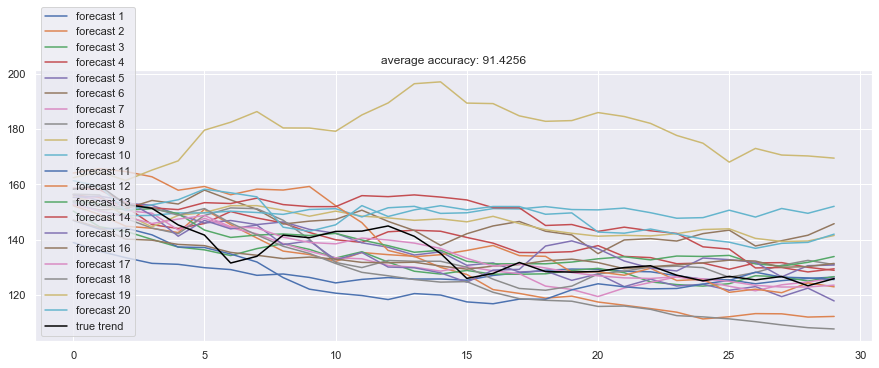

In [9]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend(loc = "lower left")
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()